# Deep Learning y Sistemas Inteligentes - Laboratorio 8
## Predicción de Meses de Ventas
- - -
### Integrantes:
- Diego Alberto Leiva 21752
- José Pablo Orellana 21970
- María Marta Ramírez 21342
- - -

Se le proporcionan 5 años de datos de ventas de artículos de una cadena de tiendas y se le pide que prediga 3 meses de ventas para 50 artículos diferentes en 10 tiendas diferentes. Descarguen el dataset de Kaggle aquí por favor. 

# Task 1


### Librerías

In [4]:
# Manipulacion de datos
import pandas as pd
import numpy as np
import os

# Librerias para visualizacion
import matplotlib.pyplot as plt
import seaborn as sns

# Librerias para PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Librerias para preprocesamiento
from sklearn.preprocessing import StandardScaler

# libreiras para pipeline
from sklearn.pipeline import make_pipeline

# Modelo
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

from datetime import timedelta, datetime

### Cargar el Dataset

In [5]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

### Visualizar estructura e información general del dataset

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      45000 non-null  int64 
 1   date    45000 non-null  object
 2   store   45000 non-null  int64 
 3   item    45000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.4+ MB


In [8]:
print(f"El dataset contiente: {train_df.shape[0]} observaciones y {train_df.shape[1]} variables")
print(f"El dataset contiente: {test_df.shape[0]} observaciones y {test_df.shape[1]} variables")

El dataset contiente: 913000 observaciones y 4 variables
El dataset contiente: 45000 observaciones y 4 variables


In [9]:
train_df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [10]:
test_df.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


#### Variables identificadas
- **id:** Identificador unico 
- **date:** Fecha de la venta
- **store:** Tienda que realizó la venta
- **item:** Objeto vendido
- **sales:** Ventas de ciertos items

### Procesamiento y Limpieza de Datos
#### Verificación y manejo de valores nulos o faltantes
##### Visualizar la data faltante

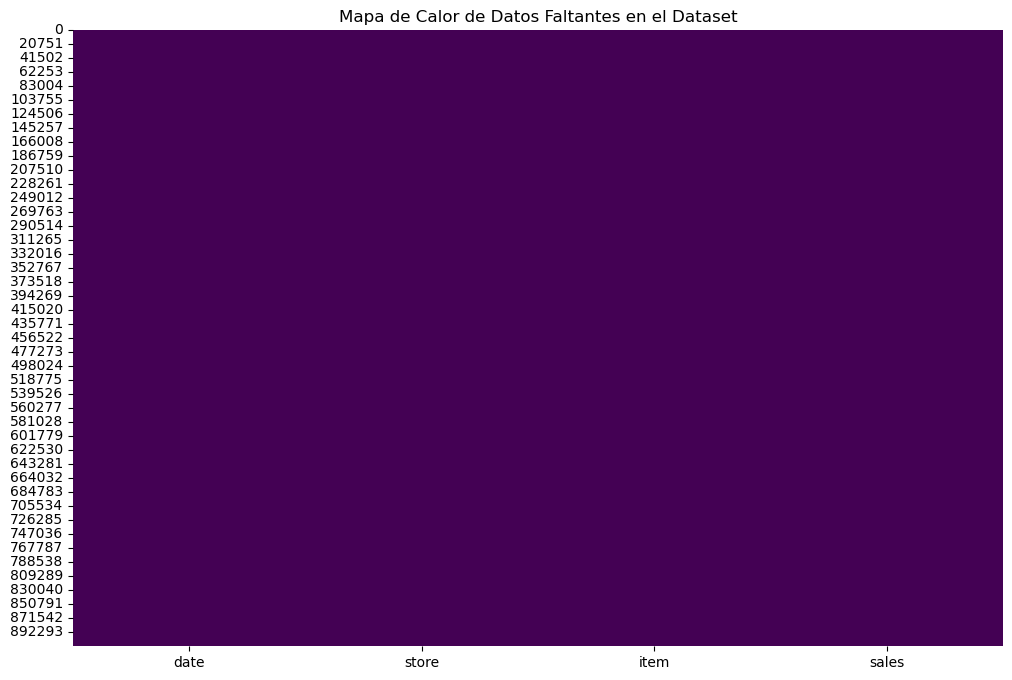

In [11]:
# Crear un mapa de calor para visualizar los datos faltante
plt.figure(figsize=(12, 8))
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title('Mapa de Calor de Datos Faltantes en el Dataset')
plt.show()

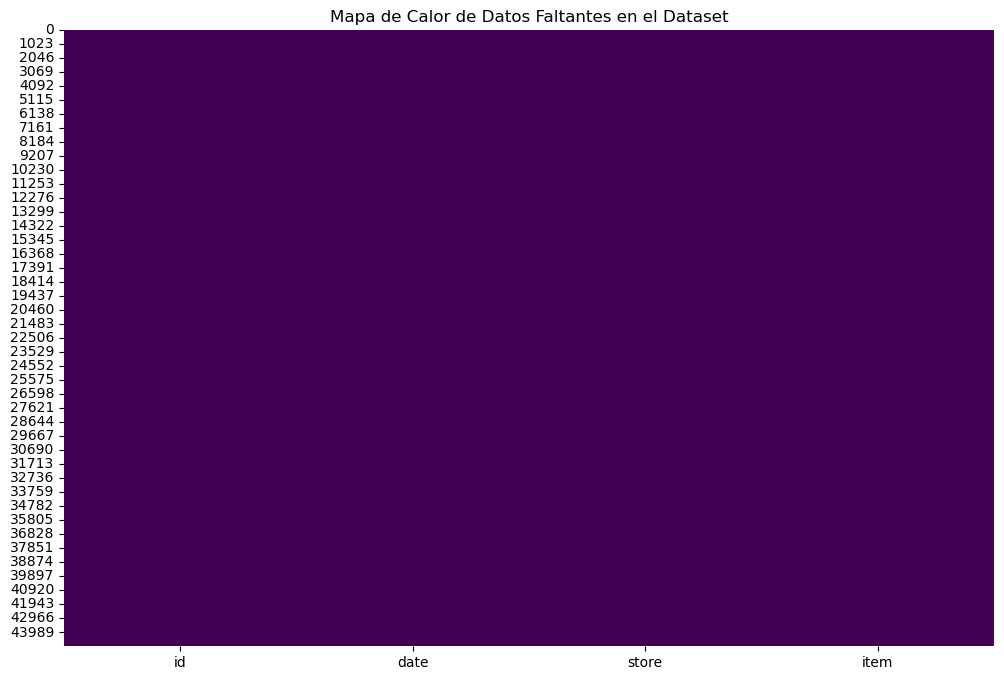

In [12]:
# Crear un mapa de calor para visualizar los datos faltante
plt.figure(figsize=(12, 8))
sns.heatmap(test_df.isnull(), cbar=False, cmap='viridis')
plt.title('Mapa de Calor de Datos Faltantes en el Dataset')
plt.show()

##### Porcentaje de valores nulos

In [13]:
# Calcular el porcentaje de valores nulos para cada tipo
null_percentage_numeric = train_df.isnull().mean() * 100
print(f"Porcentaje de data faltante en variables numericas:")
print(null_percentage_numeric.sort_values(ascending=False))

Porcentaje de data faltante en variables numericas:
date     0.0
store    0.0
item     0.0
sales    0.0
dtype: float64


In [14]:
# Calcular el porcentaje de valores nulos para cada tipo
null_percentage_numeric = test_df.isnull().mean() * 100
print(f"Porcentaje de data faltante en variables numericas:")
print(null_percentage_numeric.sort_values(ascending=False))

Porcentaje de data faltante en variables numericas:
id       0.0
date     0.0
store    0.0
item     0.0
dtype: float64


Como se puede observar en lo anterior mostrado. En el dataset no se poseen valores nulos por lo que no se deberá proceder con la eliminación o sustitución de valores en alguna de las variables presentes.

#### Conversión de fechas
Para este dataset tenemos fechas por lo que se procederá a darle un formato específico a estas variables.

In [15]:
# Convertir la columna 'date' a formato datetime
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

# Crear nuevas características basadas en la fecha
train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.day
train_df['day_of_week'] = train_df['date'].dt.dayofweek

test_df['year'] = test_df['date'].dt.year
test_df['month'] = test_df['date'].dt.month
test_df['day'] = test_df['date'].dt.day
test_df['day_of_week'] = test_df['date'].dt.dayofweek


In [16]:
train_df.head()

,date,store,item,sales,year,month,day,day_of_week
0,2013-01-01,1,1,13,2013,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2
2,2013-01-03,1,1,14,2013,1,3,3
3,2013-01-04,1,1,13,2013,1,4,4
4,2013-01-05,1,1,10,2013,1,5,5


In [17]:
test_df.head()

,id,date,store,item,year,month,day,day_of_week
0,0,2018-01-01,1,1,2018,1,1,0
1,1,2018-01-02,1,1,2018,1,2,1
2,2,2018-01-03,1,1,2018,1,3,2
3,3,2018-01-04,1,1,2018,1,4,3
4,4,2018-01-05,1,1,2018,1,5,4


Es probable que se necesite convertir la columna date a un formato de fecha y extraer características adicionales como el mes, el día o el día de la semana para que el modelo pueda capturar patrones temporales.

#### Escalado de datos

In [18]:
# Normalizar la columna 'sales'
scaler = MinMaxScaler()
train_df['sales_scaled'] = scaler.fit_transform(train_df[['sales']])

In [19]:
train_df.head()

,date,store,item,sales,year,month,day,day_of_week,sales_scaled
0,2013-01-01,1,1,13,2013,1,1,1,0.056277
1,2013-01-02,1,1,11,2013,1,2,2,0.047619
2,2013-01-03,1,1,14,2013,1,3,3,0.060606
3,2013-01-04,1,1,13,2013,1,4,4,0.056277
4,2013-01-05,1,1,10,2013,1,5,5,0.043290


### División de series temporales

In [20]:
# Ordenar los datos por fecha
train_df = train_df.sort_values('date')

# Definir las fechas para el corte de validación y prueba (asumimos que la fecha más reciente es para el test)
test_size = 3 * 30  # Aproximadamente 3 meses
val_size = 3 * 30   # Aproximadamente 3 meses

# Dividir en conjuntos de entrenamiento, validación y prueba
train_data = train_df.iloc[:-val_size-test_size]
val_data = train_df.iloc[-val_size-test_size:-test_size]
test_data = train_df.iloc[-test_size:]

print(f'Tamaño del conjunto de entrenamiento: {len(train_data)}')
print(f'Tamaño del conjunto de validación: {len(val_data)}')
print(f'Tamaño del conjunto de prueba: {len(test_data)}')


Tamaño del conjunto de entrenamiento: 912820
Tamaño del conjunto de validación: 90
Tamaño del conjunto de prueba: 90


### Generación de secuencias

In [21]:
def create_sequences(data, target_col, window_size=30):
    sequences = []
    targets = []
    
    for i in range(len(data) - window_size):
        seq = data.iloc[i:i+window_size][target_col].values
        target = data.iloc[i+window_size][target_col]
        sequences.append(seq)
        targets.append(target)
    
    return np.array(sequences), np.array(targets)

# Crear secuencias para entrenamiento y validación
window_size = 30  # Una ventana de 30 días de datos históricos
train_sequences, train_targets = create_sequences(train_data, 'sales_scaled', window_size)
val_sequences, val_targets = create_sequences(val_data, 'sales_scaled', window_size)
test_sequences, test_targets = create_sequences(test_data, 'sales_scaled', window_size)

print(f'Tamaño de las secuencias de entrenamiento: {train_sequences.shape}')
print(f'Tamaño de las secuencias de validación: {val_sequences.shape}')
print(f'Tamaño de las secuencias de prueba: {test_sequences.shape}')


Tamaño de las secuencias de entrenamiento: (912790, 30)
Tamaño de las secuencias de validación: (60, 30)
Tamaño de las secuencias de prueba: (60, 30)


### LSTM (Long Short-Term Memory)

In [22]:
# Definir el modelo
def build_lstm_model(input_shape):
    model = Sequential()

    # Capa LSTM 1
    model.add(LSTM(units=64, return_sequences=True, input_shape=input_shape))
    model.add(BatchNormalization())  # Normalización por batches
    model.add(Dropout(0.2))          # Dropout del 20% para evitar overfitting

    # Capa LSTM 2
    model.add(LSTM(units=32, return_sequences=False))
    model.add(BatchNormalization())  # Normalización por batches
    model.add(Dropout(0.2))          # Dropout del 20% para evitar overfitting

    # Capa Densa intermedia
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))          # Otro Dropout del 20%

    # Capa Densa de salida para predicciones
    model.add(Dense(1))  # Salida de una sola unidad, ya que estamos prediciendo las ventas

    # Compilar el modelo
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

# Definir la forma de entrada basada en los datos de las secuencias
input_shape = (train_sequences.shape[1], 1)  # Ventana de 30 días y una variable (sales_scaled)
model = build_lstm_model(input_shape)

# Resumen del modelo
model.summary()


c:\anaconda\envs\deep\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,785 (120.25 KB)

 Trainable params: 30,593 (119.50 KB)

 Non-trainable params: 192 (768.00 B)

#### Entrenamiento 

In [23]:
# Definir el callback para early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',      # Monitorea la pérdida en el conjunto de validación
    patience=5,              # Detiene el entrenamiento si no hay mejora en 5 épocas
    restore_best_weights=True # Restaura los mejores pesos del modelo
)

# Entrenar el modelo
history = model.fit(
    train_sequences,          # Datos de entrada (secuencias de entrenamiento)
    train_targets,            # Objetivos (ventas escaladas para el entrenamiento)
    validation_data=(val_sequences, val_targets),  # Conjunto de validación
    epochs=50,                # Número de épocas
    batch_size=128,            # Tamaño del batch
    callbacks=[early_stopping], # Callback de early stopping
    verbose=1                 # Mostrar el progreso del entrenamiento
)

Epoch 1/50
7132/7132 ━━━━━━━━━━━━━━━━━━━━ 360s 50ms/step - loss: 0.0517 - val_loss: 0.0098
Epoch 2/50
7132/7132 ━━━━━━━━━━━━━━━━━━━━ 365s 51ms/step - loss: 0.0131 - val_loss: 0.0238
Epoch 3/50
7132/7132 ━━━━━━━━━━━━━━━━━━━━ 369s 52ms/step - loss: 0.0131 - val_loss: 0.0090
Epoch 4/50
7132/7132 ━━━━━━━━━━━━━━━━━━━━ 315s 44ms/step - loss: 0.0130 - val_loss: 0.0115
Epoch 5/50
7132/7132 ━━━━━━━━━━━━━━━━━━━━ 314s 44ms/step - loss: 0.0130 - val_loss: 0.0091
Epoch 6/50
7132/7132 ━━━━━━━━━━━━━━━━━━━━ 326s 46ms/step - loss: 0.0130 - val_loss: 0.0101
Epoch 7/50
7132/7132 ━━━━━━━━━━━━━━━━━━━━ 290s 41ms/step - loss: 0.0130 - val_loss: 0.0098
Epoch 8/50
7132/7132 ━━━━━━━━━━━━━━━━━━━━ 310s 43ms/step - loss: 0.0129 - val_loss: 0.0094


#### Evaluar el rendimiento

In [24]:
# Evaluar el modelo en el conjunto de prueba
test_loss = model.evaluate(test_sequences, test_targets)
print(f'Pérdida en el conjunto de prueba: {test_loss}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0156
Pérdida en el conjunto de prueba: 0.014686761423945427


In [25]:
# Hacer predicciones en el conjunto de prueba
predictions = model.predict(test_sequences)

# Mostrar algunas predicciones junto con los valores reales
for i in range(5):  # Mostrar las primeras 5 predicciones
    print(f'Predicción: {predictions[i]}, Valor real: {test_targets[i]}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 434ms/step
Predicción: [0.24192224], Valor real: 0.2683982683982684
Predicción: [0.24394609], Valor real: 0.3203463203463203
Predicción: [0.24785867], Valor real: 0.3203463203463203
Predicción: [0.25078544], Valor real: 0.3116883116883117
Predicción: [0.2532299], Valor real: 0.30735930735930733


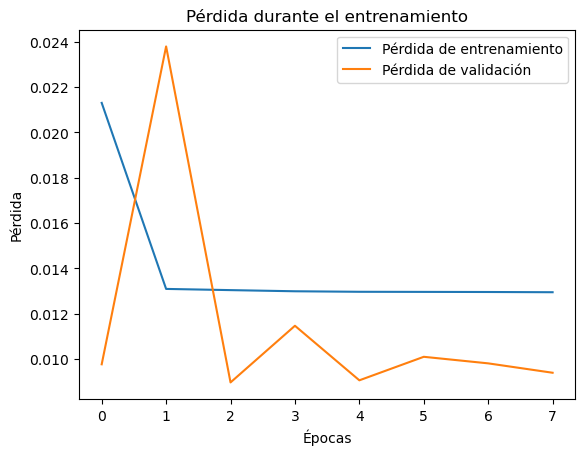

In [26]:
# Graficar la pérdida
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

#### Forecasting

In [28]:
forecast_results = []

# Definir el número de tiendas, artículos y días para las predicciones
num_stores = 10  # 10 tiendas
num_items = 50   # 50 artículos
batch_size = 1000  # Tamaño del lote (ajustable)
days_to_predict = 90  # 90 días de predicciones

# Crear una lista para todas las secuencias de prueba
sequences_list = []

# Recorremos todas las combinaciones de tienda y artículo
for store_id in range(1, num_stores + 1):
    for item_id in range(1, num_items + 1):
        
        # Preparar la secuencia de prueba para cada tienda y artículo
        item_sequence = test_sequences[i:i+1]  # Reemplaza con tu secuencia real
        
        # Almacenar la secuencia en la lista de secuencias
        sequences_list.append(item_sequence)

# Verificar el número total de secuencias
total_sequences = len(sequences_list)

# Dividir las secuencias en lotes
num_batches = total_sequences // batch_size

# Procesar los lotes completos
for batch_idx in range(num_batches):
    # Seleccionar el lote correspondiente
    batch_sequences = np.concatenate(sequences_list[batch_idx * batch_size:(batch_idx + 1) * batch_size], axis=0)
    
    # Realizar la predicción para el lote completo
    batch_predictions = model.predict(batch_sequences)
    
    # Almacenar las predicciones para cada tienda y artículo dentro del lote
    for idx, prediction in enumerate(batch_predictions):
        store_id = (batch_idx * batch_size + idx) // num_items + 1
        item_id = (batch_idx * batch_size + idx) % num_items + 1
        
        forecast_results.append({
            'store': store_id,
            'item': item_id,
            'predictions': prediction.flatten()  # Aplanar las predicciones
        })

# Procesar las secuencias restantes (si no son un múltiplo exacto del tamaño del lote)
if total_sequences % batch_size != 0:
    # Seleccionar las secuencias restantes
    remaining_sequences = np.concatenate(sequences_list[num_batches * batch_size:], axis=0)
    
    # Realizar la predicción para las secuencias restantes
    remaining_predictions = model.predict(remaining_sequences)
    
    # Almacenar las predicciones para las secuencias restantes
    for idx, prediction in enumerate(remaining_predictions):
        store_id = (num_batches * batch_size + idx) // num_items + 1
        item_id = (num_batches * batch_size + idx) % num_items + 1
        
        forecast_results.append({
            'store': store_id,
            'item': item_id,
            'predictions': prediction.flatten()
        })

# Mostrar las primeras 5 predicciones si hay suficientes resultados
if len(forecast_results) >= 5:
    for i in range(5):
        print(f"Tienda: {forecast_results[i]['store']}, Artículo: {forecast_results[i]['item']}, Predicciones: {forecast_results[i]['predictions'][:5]}")
else:
    print("No se han generado suficientes predicciones.")


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Tienda: 1, Artículo: 1, Predicciones: [0.24192224]
Tienda: 1, Artículo: 2, Predicciones: [0.24192224]
Tienda: 1, Artículo: 3, Predicciones: [0.24192224]
Tienda: 1, Artículo: 4, Predicciones: [0.24192224]
Tienda: 1, Artículo: 5, Predicciones: [0.24192224]


#### Visualización de resultados

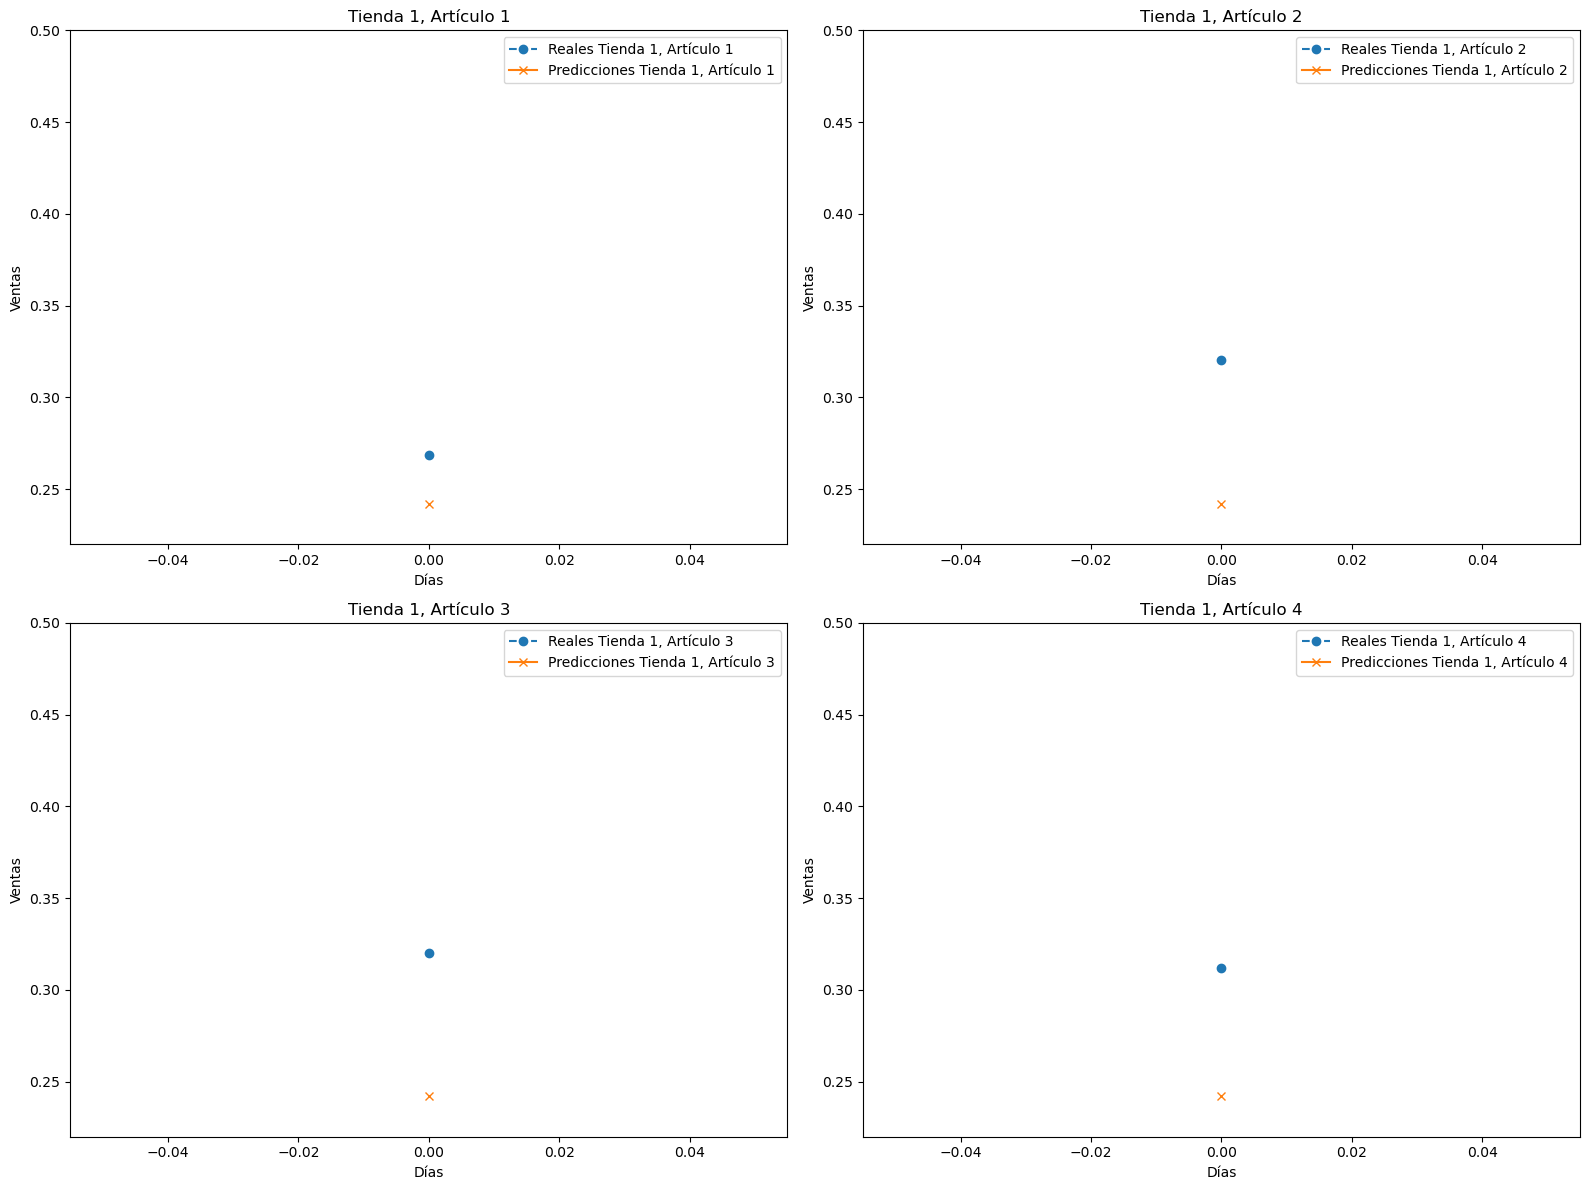

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))  
axes = axes.flatten()  

for i in range(4):  # Visualizar 4 tiendas
    store_id = forecast_results[i]['store']
    item_id = forecast_results[i]['item']
    predictions = forecast_results[i]['predictions']
    
    real_sales = test_targets[i]  # Extraemos el valor escalar correspondiente directamente

    # Graficar ventas reales vs predicciones en el subplot correspondiente
    axes[i].plot([real_sales], label=f'Reales Tienda {store_id}, Artículo {item_id}', linestyle='--', marker='o')
    axes[i].plot(predictions.flatten(), label=f'Predicciones Tienda {store_id}, Artículo {item_id}', marker='x')

    axes[i].set_title(f'Tienda {store_id}, Artículo {item_id}')
    axes[i].set_xlabel('Días')
    axes[i].set_ylabel('Ventas')

    axes[i].set_ylim(0.22, 0.5)  # Rango ajustado del eje Y para una visualización más realista

    axes[i].legend()

plt.tight_layout()
plt.show()


In [30]:
import os
import pandas as pd
import numpy as np
from datetime import timedelta, datetime

# Definir la fecha de inicio para las predicciones
fecha_inicio = datetime.strptime('01/01/2018', '%d/%m/%Y')

# Verificar que forecast_results tiene datos
if not forecast_results:
    raise ValueError("El diccionario 'forecast_results' está vacío o no contiene datos válidos.")

# Crear una lista para almacenar las predicciones
predicciones_list = []

# Recorrer 'forecast_results' y verificar que las claves y valores están presentes
for result in forecast_results:
    if 'store' in result and 'item' in result and 'predictions' in result:
        store_id = result['store']
        item_id = result['item']
        predictions = result['predictions']
        
        if predictions is None or len(predictions) == 0:
            print(f"Advertencia: No se encontraron predicciones para la tienda {store_id} y el artículo {item_id}.")
            continue

        # Aplanar las predicciones
        predictions = predictions.flatten()

        # Generar las fechas correspondientes a cada día durante los 90 días
        fechas = [fecha_inicio + timedelta(days=i) for i in range(len(predictions))]

        # Crear un DataFrame temporal para cada tienda/artículo
        df_temp = pd.DataFrame({
            'date': fechas,
            'store': store_id,
            'item': item_id,
            'sales': predictions  # Cambiar nombre a 'sales'
        })

        predicciones_list.append(df_temp)
    else:
        print("Advertencia: Faltan claves necesarias en un resultado. Revisar estructura de 'forecast_results'.")

# Verificar que la lista de predicciones no está vacía
if not predicciones_list:
    raise ValueError("No se generaron predicciones. Verificar el contenido de 'forecast_results'.")

# Concatenar todas las predicciones en un solo DataFrame
df_predicciones = pd.concat(predicciones_list, ignore_index=True)

# Desescalar las predicciones a sus valores originales y convertirlas a enteros
df_predicciones['sales'] = scaler.inverse_transform(df_predicciones[['sales']])
df_predicciones['sales'] = df_predicciones['sales'].round().astype(int)  # Convertir a enteros

# Ordenar primero por tienda, luego por artículo, y por último por fecha
df_predicciones = df_predicciones.sort_values(by=['store', 'item', 'date'])

# Verificar si la carpeta 'data' existe
output_dir = 'data'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Guardar el DataFrame en un archivo CSV ordenado correctamente
output_file = os.path.join(output_dir, 'predicciones.csv')
df_predicciones.to_csv(output_file, index=False, date_format='%d/%m/%Y')

print(f"El archivo CSV ordenado ha sido guardado en {output_file}")


El archivo CSV ordenado ha sido guardado en data\predicciones.csv


# Task 2

**Responda claramente y con una extensión adecuada las siguientes preguntas:**

**¿Cuál es el problema del gradiente de fuga en las redes LSTM y cómo afecta la efectividad de LSTM para el pronóstico de series temporales?**
- El problema del gradiente de fuga ocurre cuando los gradientes, durante el entrenamiento de redes neuronales recurrentes (RNN) como las LSTM, se vuelven extremadamente pequeños. Esto sucede debido a la multiplicación repetida de derivadas (menores que uno) en la retropropagación a lo largo del tiempo, lo que lleva a una disminución exponencial del gradiente.

**¿Cómo se aborda la estacionalidad en los datos de series temporales cuando se utilizan LSTM para realizar pronósticos y qué papel juega la diferenciación en el proceso?**
- La estacionalidad es un patrón recurrente que aparece a intervalos regulares en los datos de series temporales, como los ciclos anuales, mensuales o diarios. Para abordar esto se podrían añadir características adicionales como el mes, día de la semana o cualquier otra variable que represente la estacionalidad de los datos. Esto ayuda al modelo a tener en cuenta estos ciclos sin depender únicamente de la secuencia. O bien se podría aumentar el tamaño de la ventana o la longitud de la secuencia de entrada, la LSTM puede aprender patrones estacionales, ya que puede "recordar" información sobre el comportamiento cíclico en los datos.

**¿Cuál es el concepto de "tamaño de ventana" en el pronóstico de series temporales con LSTM y cómo afecta la elección del tamaño de ventana a la capacidad del modelo para capturar patrones a corto y largo plazo?**
- El tamaño de ventana o window size, en el pronóstico de series temporales con LSTM se refiere a la cantidad de datos pasados que se toman como entrada para predecir un valor futuro. Elegir el tamaño de ventana adecuado es clave para el rendimiento del modelo. Si el tamaño es demasiado pequeño, el modelo no podrá aprender patrones a largo plazo, si es demasiado grande, el entrenamiento puede volverse lento y propenso a errores.